### 0. Imports

In [1]:
%load_ext autoreload
%autoreload 2

# Data transformation
# ------------------------------------------------------
import pandas as pd
import numpy as np
import math

# Visualizations
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px

# Preprocessing and clustering
# ------------------------------------------------------
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, MinMaxScaler, StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, pairwise_distances,  davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Handle warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("once")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# modify system variables
# -----------------------------------------------------------------------
import sys
sys.path.append("..") # append parent folder to path

# modify operating system structures
# -----------------------------------------------------------------------
import os

# import support functions
# -----------------------------------------------------------------------
import src.soporte_eda as se
import src.soporte_preprocesamiento as sp
import src.soporte_clustering as sc
import src.data_visualization_support as dvs
import src.soporte_outliers as so

# 1. Intro to clustering notebook and data import

## 1.1 Introduction

The purporse of this clustering notebook is to perform the necessary preprocessing, configuration, tuning and evaluation of different clustering methods to identify different groups of products.

## 1.2 Data import

In [2]:
global_superstore = pd.read_pickle("../data/cleaned/global_superstore.pkl")

# 2. Clustering - customers

## 2.1 Features to introduce

## 2.2 Aggregation

To cluster by customer, it is necessary for the data to have each row to represent each customer.

##### Calculate avg orders month

In [3]:
global_superstore["year_month"] = global_superstore["order_date"].dt.to_period('M')
global_superstore["year_month"]

0        2012-07
1        2013-02
2        2013-10
3        2013-01
4        2013-11
          ...   
51285    2014-06
51286    2014-06
51287    2013-12
51288    2012-02
51289    2012-05
Name: year_month, Length: 51290, dtype: period[M]

In [6]:
avg_purchase_freq = global_superstore.groupby(
    ["product_id", "year_month"]
).agg(
    orders_month=("order_id", "nunique")
).groupby("product_id").agg(avg_orders_month=("orders_month","mean"))

avg_purchase_freq.head()

avg_orders_month
product_id                  
PR-0                    1.00
PR-1                    1.25
PR-10                   1.00
PR-100                  1.00
PR-1000                 1.25

##### Correlation of spending with discounts

discount_corr
product_id               
PR-2448         -0.390521
PR-511          -0.333333
PR-182          -0.007382
PR-3431         -0.891412
PR-2082          0.020477

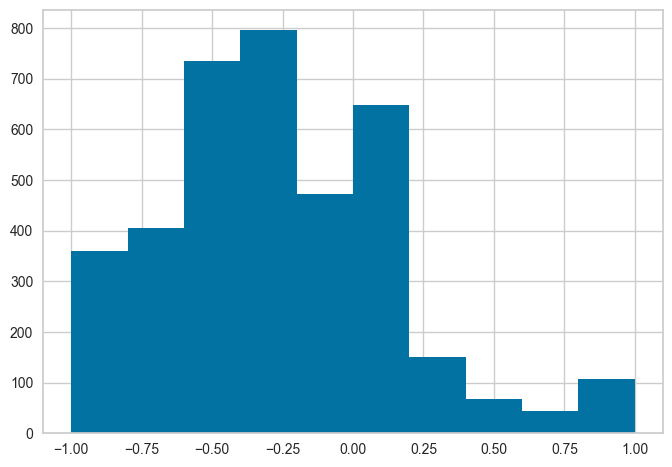

In [18]:
# groupby client and calculate
corr_product = global_superstore.groupby('product_id').apply(sc.calculate_discount_expense_correlation).reset_index()
corr_product.columns = ['product_id', 'discount_corr']
corr_product.set_index("product_id",inplace=True)
corr_product['discount_corr'].hist()
corr_product.sample(5)

<Axes: xlabel='discount', ylabel='sales'>

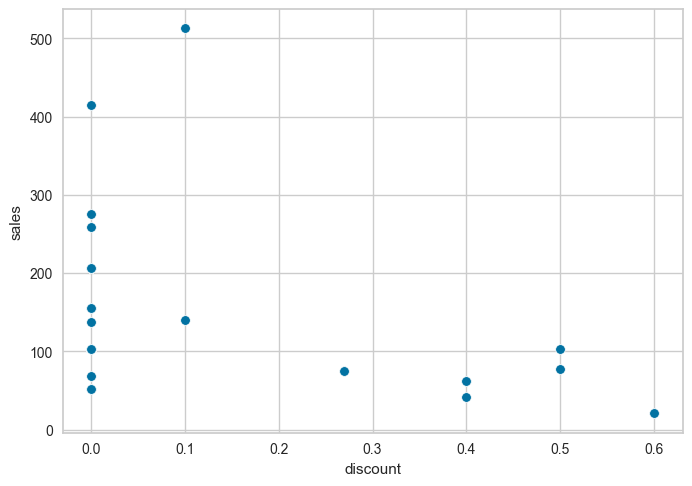

In [19]:
sns.scatterplot(data=global_superstore[global_superstore["product_id"]=="PR-1225"],
                x="discount",
                y="sales")

#### Avg quantity per order, avg ppu per order & avg discount

In [20]:
# calculate necessary columns before aggregation
global_superstore["discounted_price"] = global_superstore["sales"]/(1-global_superstore["discount"]) - global_superstore["sales"]
global_superstore["original_price"] = global_superstore["sales"] + global_superstore["discounted_price"]
global_superstore["discounted_shipping"] = global_superstore["shipping_cost"]/(1-global_superstore["discount"]) - global_superstore["shipping_cost"]
global_superstore["profit_before_discounts"] = (global_superstore["discounted_shipping"] + 
                                                global_superstore["discounted_price"] + global_superstore["profit"])

# aggregation
mean_q_ppu_discount_order = (global_superstore.groupby(["product_id", "order_id"]
                    ).agg(
                        total_spending_order=("sales", "sum"),
                        total_quantity=("quantity", "sum"),
                        total_discounted_price=("discounted_price","sum"),
                        total_original_price=("original_price","sum"),
                        tota_profit_before_discounts=("profit_before_discounts","sum"))
                    .groupby("product_id")
                    .agg(
                        total_original_price=("total_original_price","sum"),
                        total_profit_before_discounts=("tota_profit_before_discounts","sum"),
                        total_quantity=("total_quantity","sum"),
                        avg_original_price=("total_original_price", "mean"),
                        avg_spending_order=("total_spending_order", "mean"),
                        avg_quantity_order=("total_quantity","mean")))

mean_q_ppu_discount_order["avg_unit_price"] = mean_q_ppu_discount_order["avg_spending_order"] / mean_q_ppu_discount_order["avg_quantity_order"]
mean_q_ppu_discount_order["unit_original_price"] = mean_q_ppu_discount_order["total_original_price"] / mean_q_ppu_discount_order["total_quantity"]
mean_q_ppu_discount_order["margin_before_discount"] = mean_q_ppu_discount_order["total_profit_before_discounts"] / mean_q_ppu_discount_order["total_original_price"]

mean_q_ppu_discount_order.head()

total_original_price  total_profit_before_discounts  \
product_id                                                        
PR-0                    11548.25                    3879.137500   
PR-1                    32056.50                    6147.974502   
PR-10                   18321.82                     508.121400   
PR-100                   2352.74                     402.288400   
PR-1000                  2879.82                    1000.113800   

           total_quantity  avg_original_price  avg_spending_order  \
product_id                                                          
PR-0                   35         1154.825000         1082.236000   
PR-1                   80         1282.260000         1145.180300   
PR-10                  22         3053.636667         2776.033333   
PR-100                 13         1176.370000         1103.978000   
PR-1000                18          575.964000          524.767200   

           avg_quantity_order avg_unit_price unit_original_price  \
product_id                                                         
PR-0                      3.5     309.210286              329.95   
PR-1                      3.2     357.868844           400.70625   
PR-10                3.666667          757.1              832.81   
PR-100                    6.5     169.842769              180.98   
PR-1000                   3.6     145.768667              159.99   

            margin_before_discount  
product_id                          
PR-0                      0.335907  
PR-1                      0.191786  
PR-10                     0.027733  
PR-100                    0.170987  
PR-1000                   0.347283

#### Joining metrics

Version with avg spending per order.

In [22]:
product_aggregated = pd.concat([avg_purchase_freq,corr_product,mean_q_ppu_discount_order[["avg_quantity_order","unit_original_price","margin_before_discount"]] ],axis=1)
print(f"The aggregated customer v1 df has {product_aggregated.shape[0]} rows")
product_aggregated.head()

The aggregated customer v1 df has 3788 rows


avg_orders_month  discount_corr avg_quantity_order  \
product_id                                                       
PR-0                    1.00      -0.431666                3.5   
PR-1                    1.25      -0.112849                3.2   
PR-10                   1.00      -0.297044           3.666667   
PR-100                  1.00      -1.000000                6.5   
PR-1000                 1.25       0.790569                3.6   

           unit_original_price  margin_before_discount  
product_id                                              
PR-0                    329.95                0.335907  
PR-1                 400.70625                0.191786  
PR-10                   832.81                0.027733  
PR-100                  180.98                0.170987  
PR-1000                 159.99                0.347283

Highly correlated features impair outlier detection and clustering, therefore let's inspect correlation:

<Axes: >

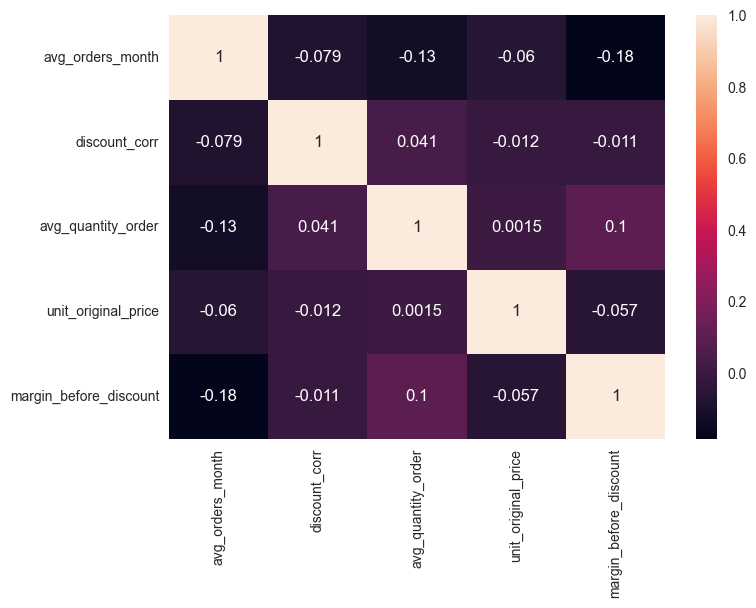

In [23]:
sns.heatmap(product_aggregated.corr(),annot=True)

There are no high correlations.

## 2.3 Preprocessing

Preprocessing should include categorical encoding, outlier handling and feature scaling. As for this iteration only numerical features are included, only feature scaling and outlier handling are needed.

#### Outlier handling

Contamination set to 3%.

In [27]:
# detect outliers
product_aggregated = product_aggregated.fillna(0)
gestor_outliers = so.GestionOutliersMultivariados(product_aggregated)

product_aggregated_outliers = gestor_outliers.detectar_outliers_if(contaminacion=0.03).replace({"outlier":{1:0,-1:1}})

Inspecting the results via pairplots:

Pairplot of version 1


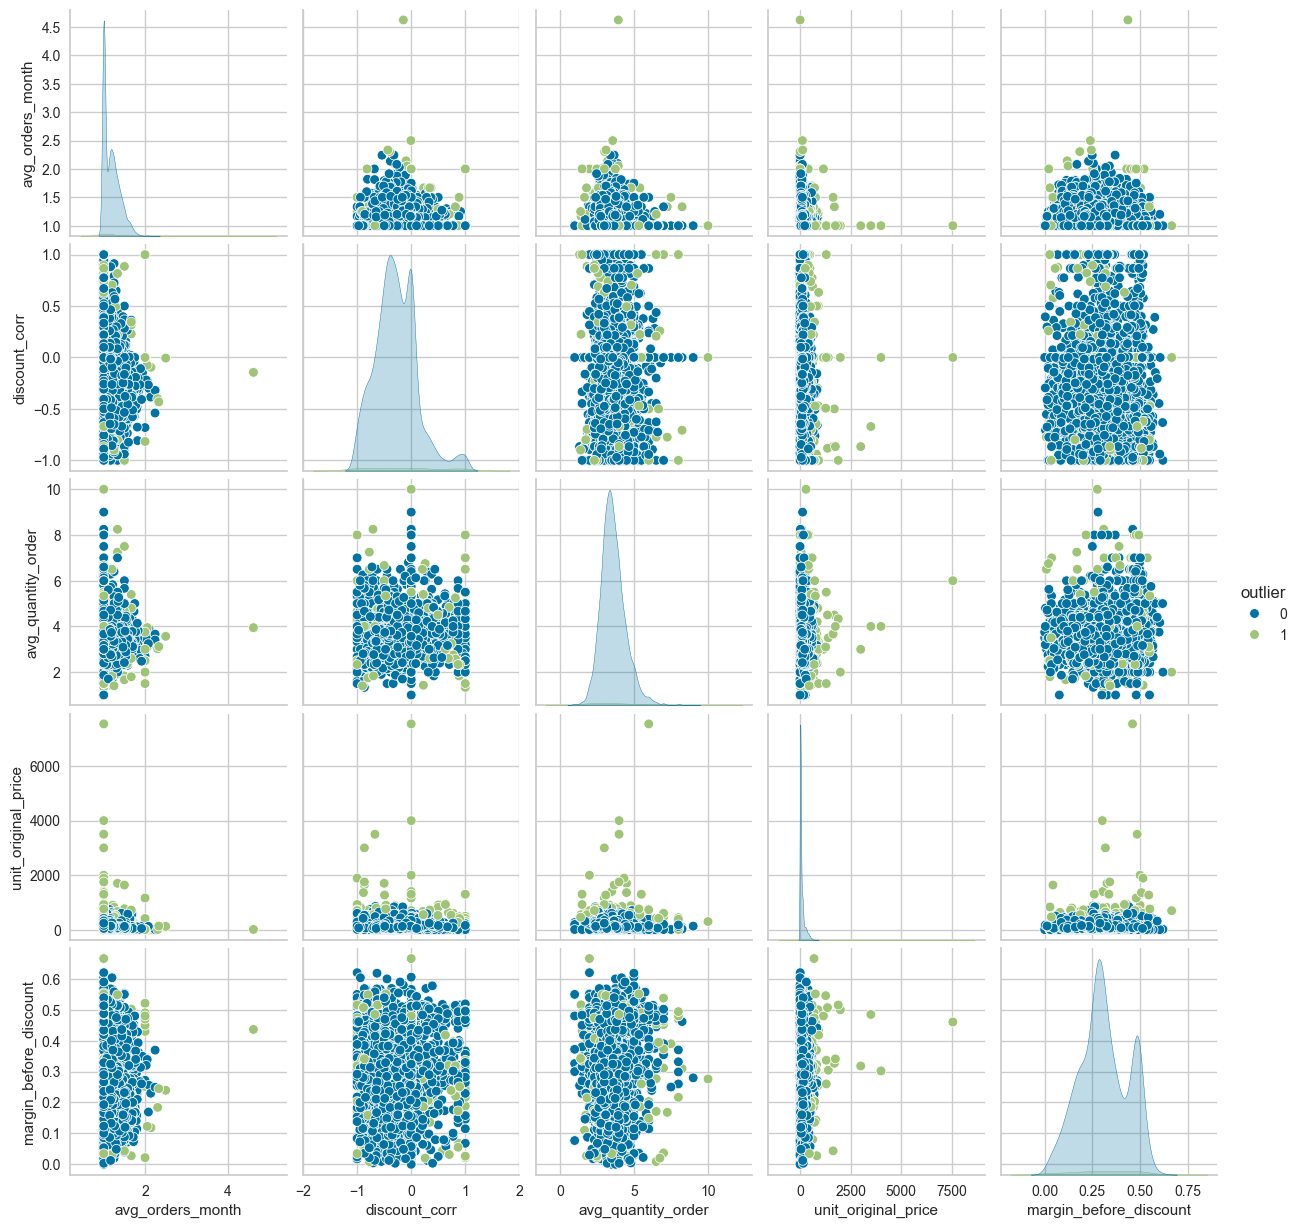

In [28]:
print("Pairplot of version 1") # cannot use titles apparently
sns.pairplot(product_aggregated_outliers, hue="outlier")
plt.show()

Outliers detected visually look correct. To not introduce noise into the model, these records are better left out of the clustering process. Therefore:

In [29]:
product_aggregated_outliers = product_aggregated_outliers[product_aggregated_outliers["outlier"]==0].drop(columns="outlier")

##### Feature scaling

To retain the maximum information possible about distances, we use robust scaling.

In [30]:
scaler = RobustScaler()

product_aggregated_scaled = pd.DataFrame(scaler.fit_transform(product_aggregated_outliers),
                                             columns=product_aggregated_outliers.columns)
product_aggregated_scaled

avg_orders_month  discount_corr  avg_quantity_order  \
0            -0.476190      -0.234345            0.000000   
1             0.357143       0.361349           -0.300000   
2             0.357143       2.049343            0.100000   
3             0.357143       1.125589           -0.900000   
4             0.293040       0.257307           -0.187500   
...                ...            ...                 ...   
3669          0.079365       0.544305           -0.738095   
3670          1.190476       0.265585           -1.083333   
3671         -0.476190       0.757206           -0.333333   
3672         -0.476190       1.506428            2.500000   
3673         -0.476190       1.195019           -0.500000   

      unit_original_price  margin_before_discount  
0                2.914144                0.208191  
1                3.615510               -0.581037  
2                1.229429                0.270490  
3                0.375573               -1.290102  
4                0.401785               -0.745256  
...                   ...                     ...  
3669             0.966993               -0.493465  
3670             0.847223               -0.360956  
3671             0.089501                1.178690  
3672             1.171342               -0.573302  
3673             2.011949               -0.043746  

[3674 rows x 5 columns]

#### Visualize results

To get an intuition for the separability of the data, let's plot the pairplots for the scaled data.

Version 1 of customer aggregated data:

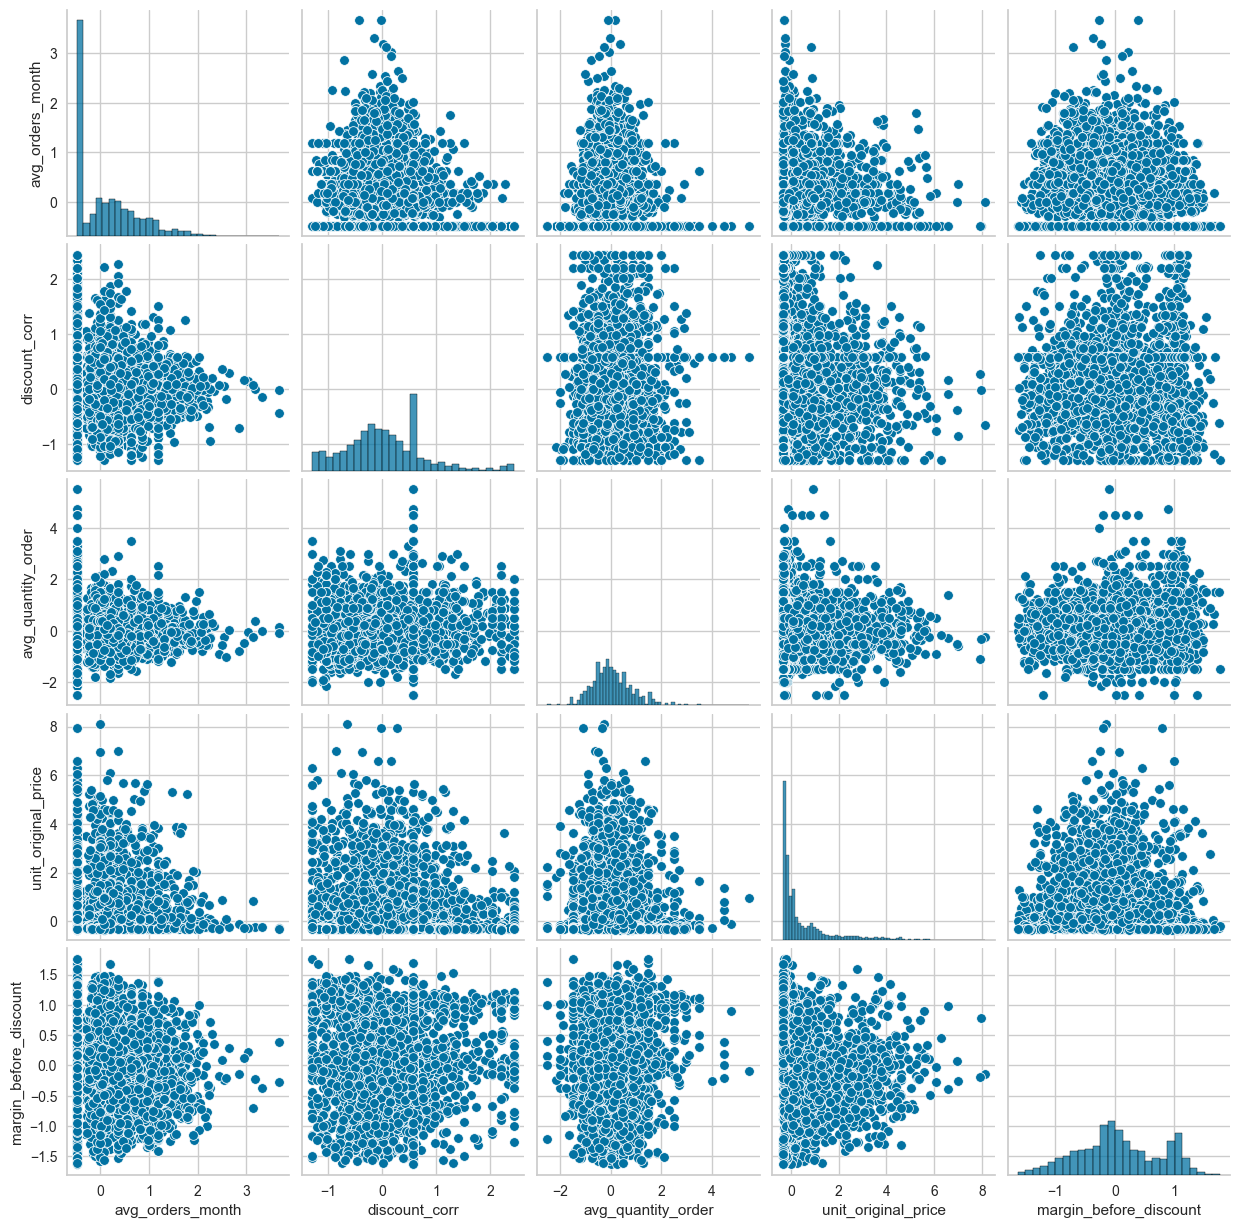

In [31]:
sns.pairplot(product_aggregated_scaled)

The data does not look easily separated. Let's proceed to observe results.

### Dimensionality reduction

The above pairplots do not show a single pairwise relationship that looks separable. There is a method for dimensionality reduction called t-SNE that helps visualize if data is separable even in a high dimensional space.

#### t-SNE

Applying t-SNE:

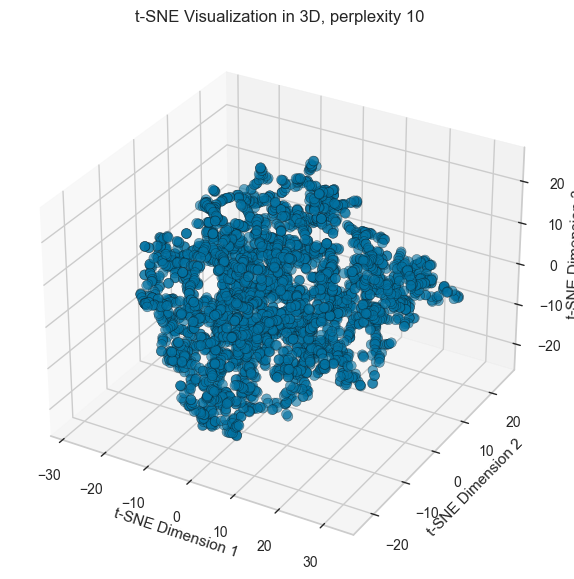

array([[ 24.780302 ,   1.0035367,   9.718461 ],
       [ 26.256475 ,   7.8427334,   3.3003592],
       [  7.6694283,   7.675609 ,  12.241348 ],
       ...,
       [-10.019214 ,   3.9954224,  15.572276 ],
       [  9.028091 ,  18.157804 ,   1.8901877],
       [ 16.765894 ,   6.5594406,  10.2759285]], dtype=float32)

In [32]:
sc.t_sne(product_aggregated_scaled,dim=3,perplexity=10)

t-SNE does not show clearly separable clusters either, although the results depend highly on the perplexity parameter. 

There is another dimensionality reduction technique worth trying, PCA.

#### Principal Component Analysis (PCA)

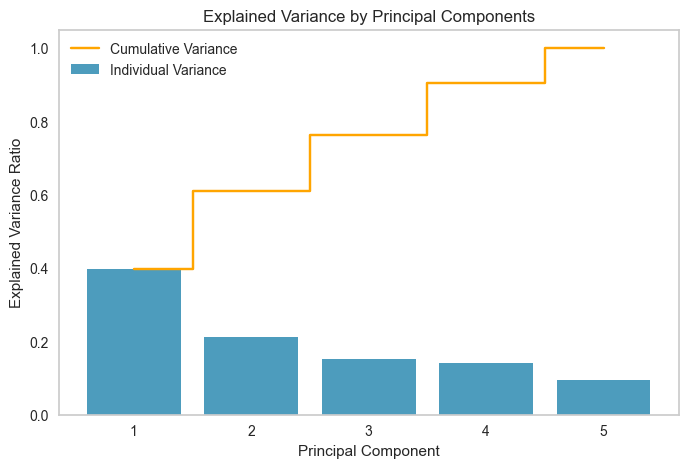

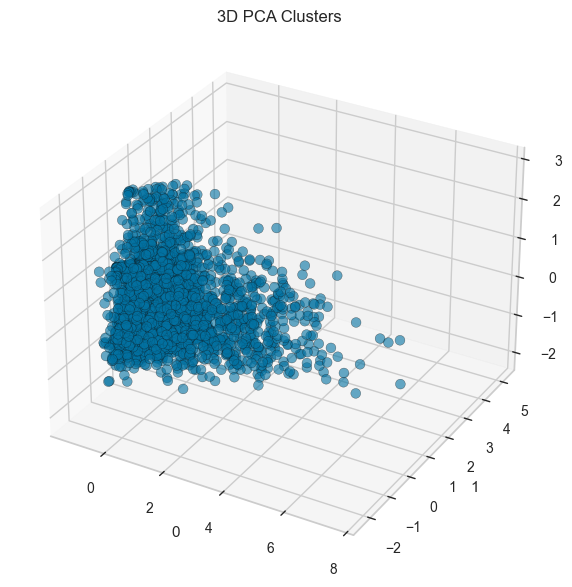

In [33]:
X_pca_v1 = sc.perform_PCA(product_aggregated_scaled)
sc.plot_3D_clusters(X_pca_v1)

PCA does not look like it does a great job separating features either. What's more, the variance plot should show logarithmic ascend, which it does not. 

Besides, its best use is to reduce dimensions while retaining the most variance. In this case, the suggested subsets only have 5 feautes, and PCA does not achieve a good enough compression. Therefore, it will be left for later when encoded categorical features are introduced into the model.

# 2.4 Clustering

### 2.4.1 Kmeans

Searching for the most optimal number of clusters for kmeans, for the first combination of features:

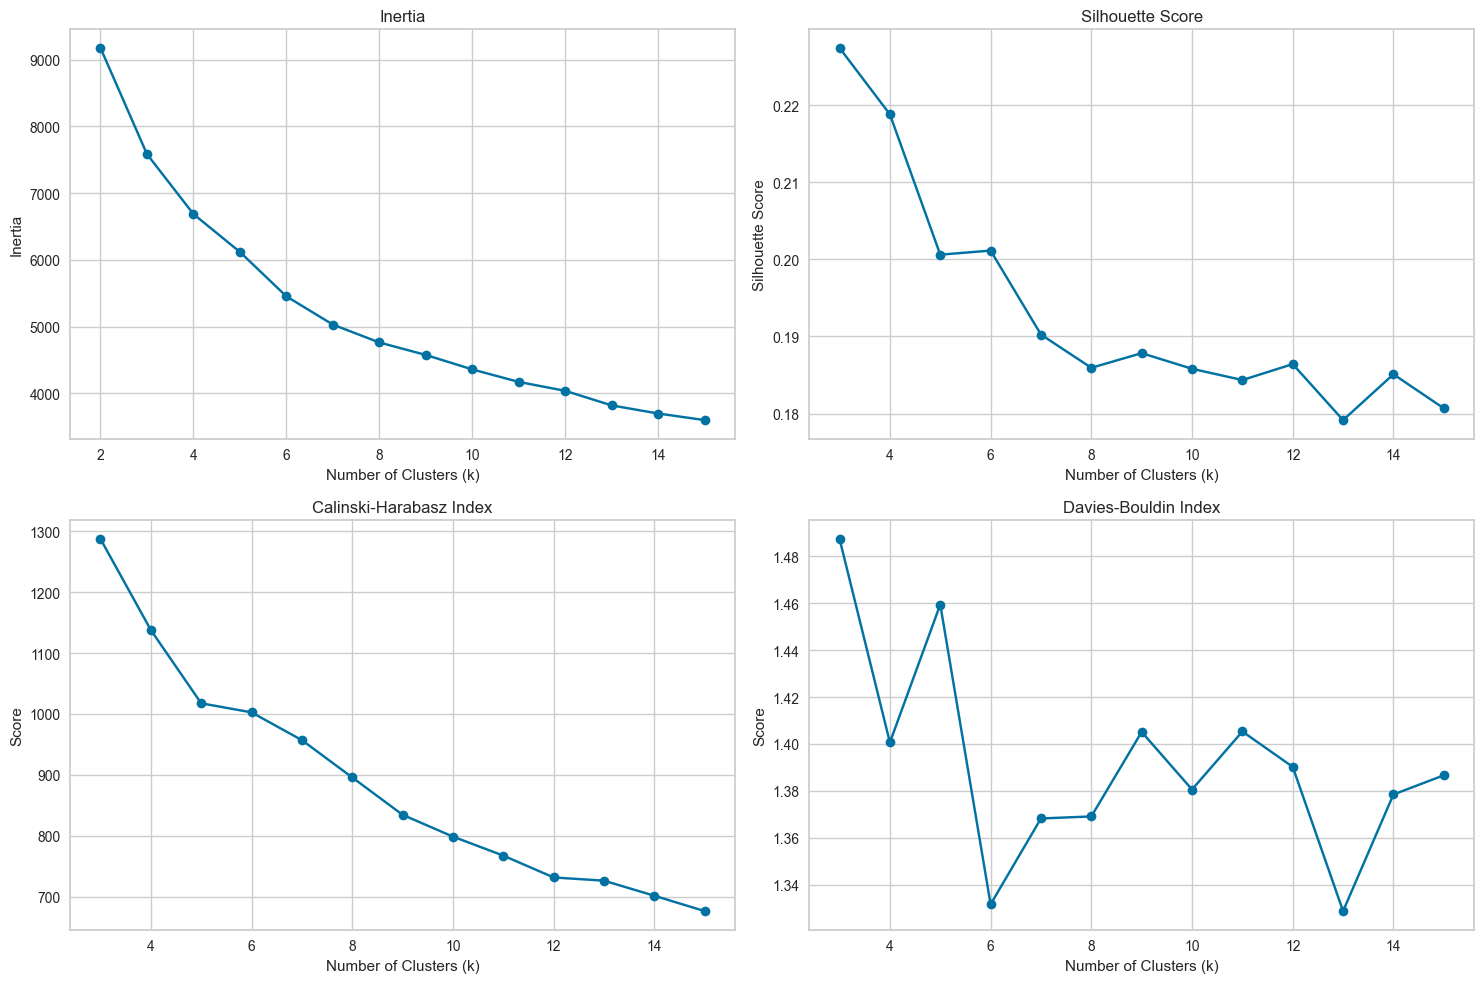

In [34]:
sc.choose_kmeans_k(product_aggregated_scaled)

4 clusters looks like a good compromise of simplicity, high Silhouette score, high Calinski score and a local minimum of Davies Bouldin. An alternative could perhaps be 6.

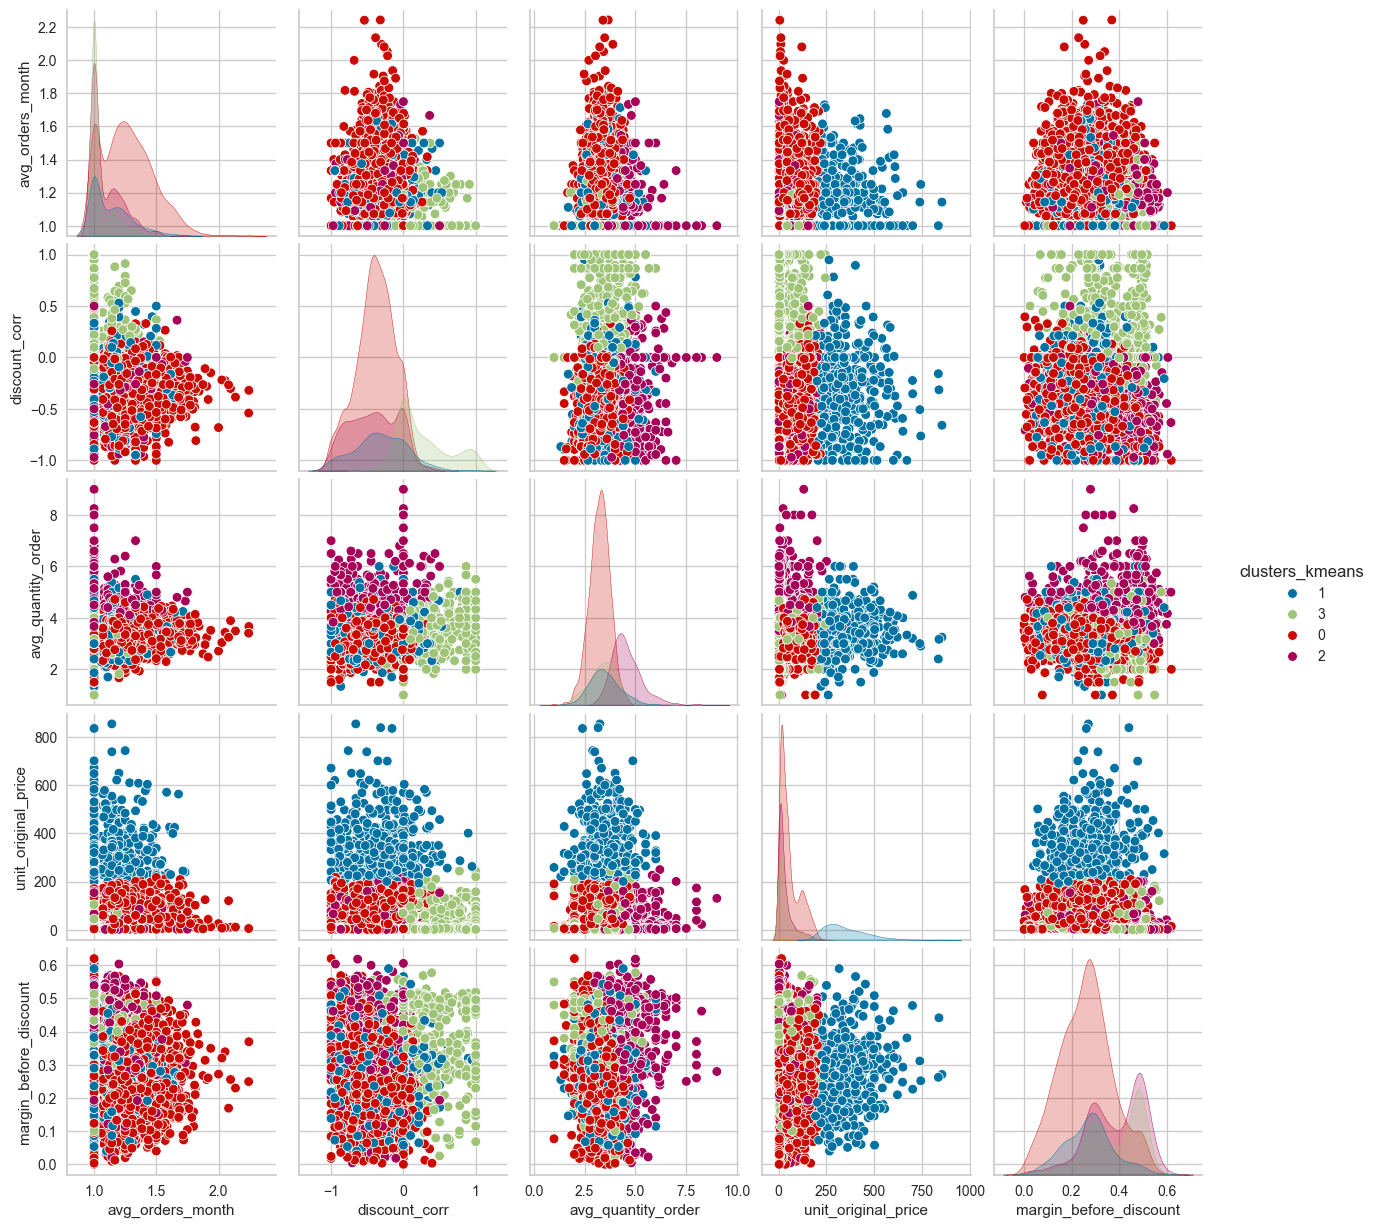

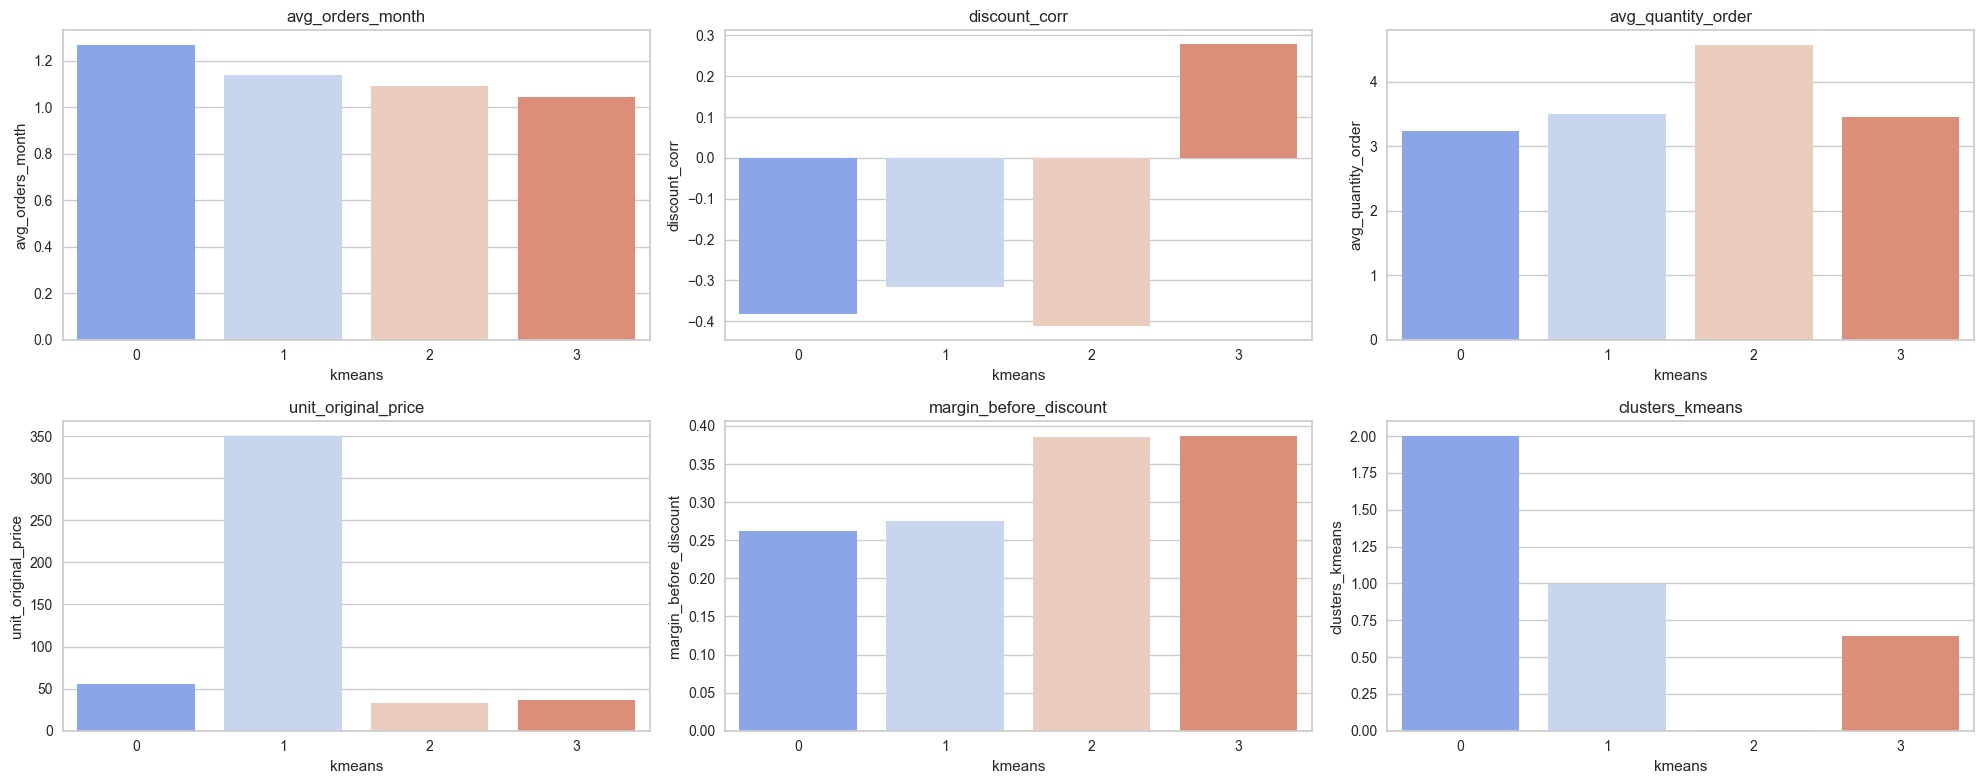

In [36]:
warnings.filterwarnings("ignore")
product_aggregated_outliers = product_aggregated_outliers.astype("float")
clusterizador = sc.Clustering(product_aggregated_outliers)

# 
clusterizador.preparar_dataframe(scaler="robust")

product_aggregated_clustered = clusterizador.modelo_kmeans(product_aggregated_outliers,4)

sns.pairplot(product_aggregated_clustered, hue="clusters_kmeans")

clusterizador.plot_clusters("kmeans")
warnings.filterwarnings("default")

In [37]:
clusterizador.calcular_metricas("kmeans")

silhouette_score  davies_bouldin_index  cardinalidad
0          0.260938              1.321205          1861

This is a very interesting set of clusters:
- Cluster 0. Low price products bought very recurringly, but for low quantities every time. Margins are on the lower end but their revenue shows no correlation with discounts.
- Cluster 1. High price products, bought on moderate quantities, with a good margin. Its sales show no correlation with discounts.
- Cluster 2. Low price products bought no so recurringly, but on high quantities every time and with great margins before discounts. Shows no correlation with discounts.
- Custer 3. Low price, low frequency products, they show high correlation with prices. These are products that might mostly be bought when there are discounts.

Below their cluster cardinality:

In [38]:
clusterizador.calcular_metricas("kmeans")
print("Clustering cardinality:")
product_aggregated_clustered.groupby("clusters_kmeans").size()

Clustering cardinality:


clusters_kmeans
0    1861
1     465
2     793
3     555
dtype: int64

This cardinality corresponds well with the interpretation. 
- Cluster 0 could be the cluster of small office supplies products that are bought recurringly.
- Cluster 3 is a small subset of products that people tend not to buy.

Let's try with 6 clusters:

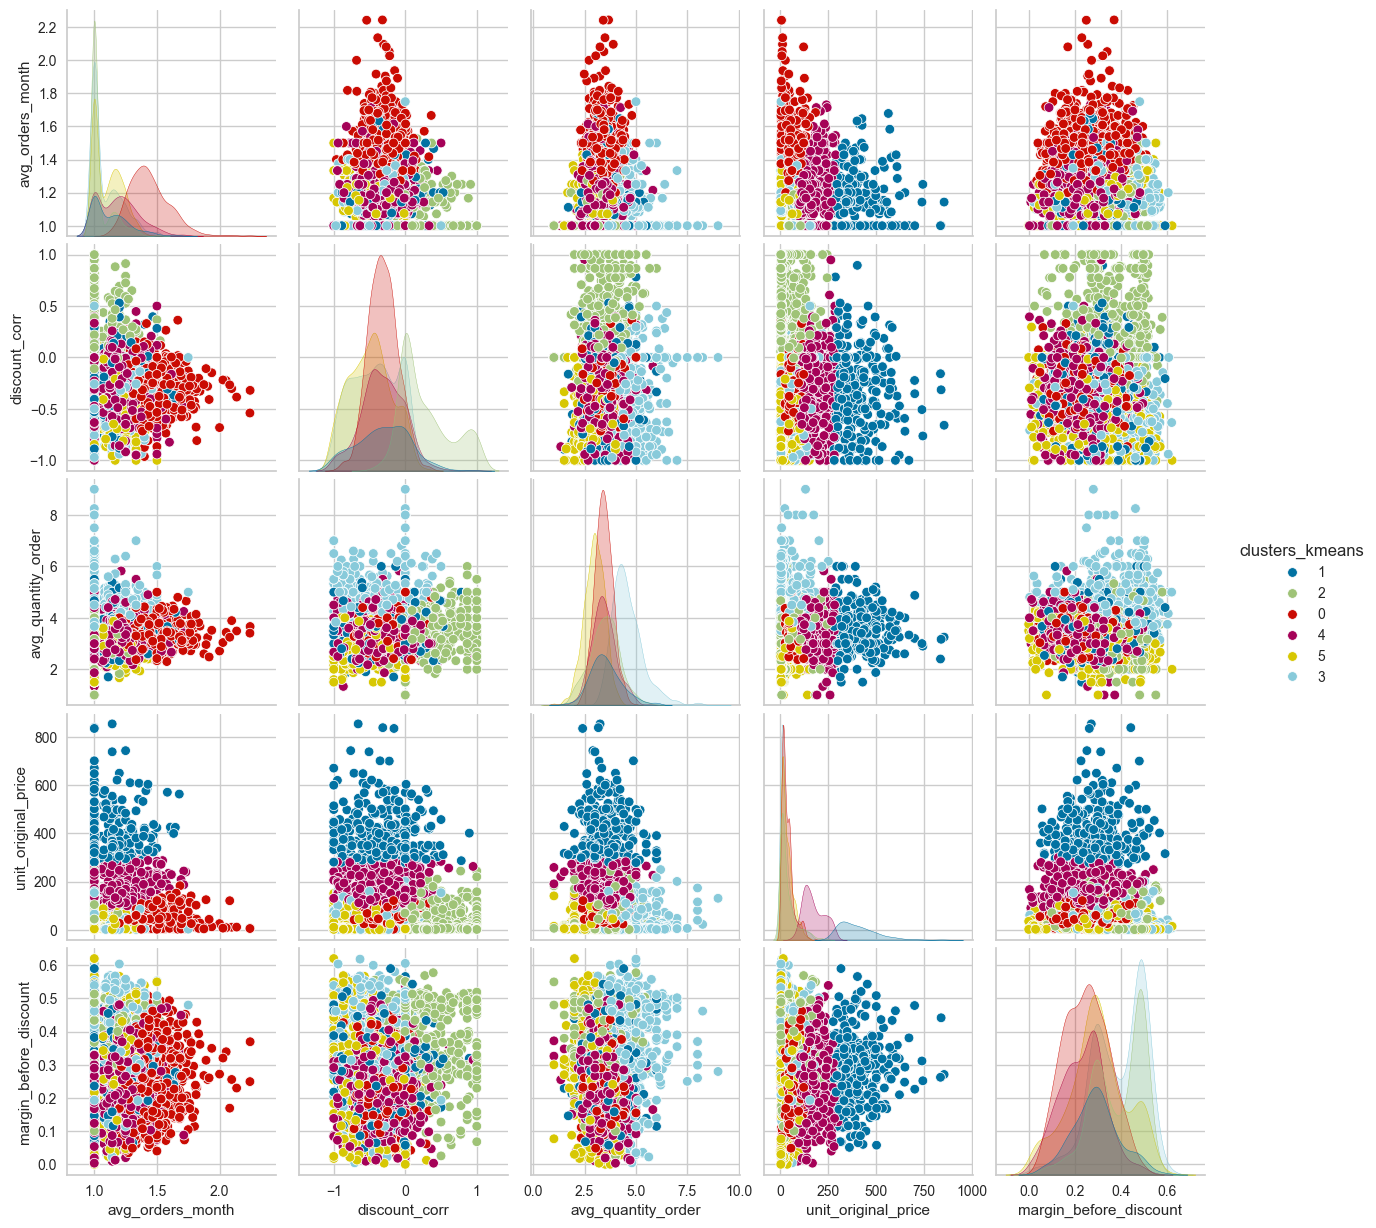

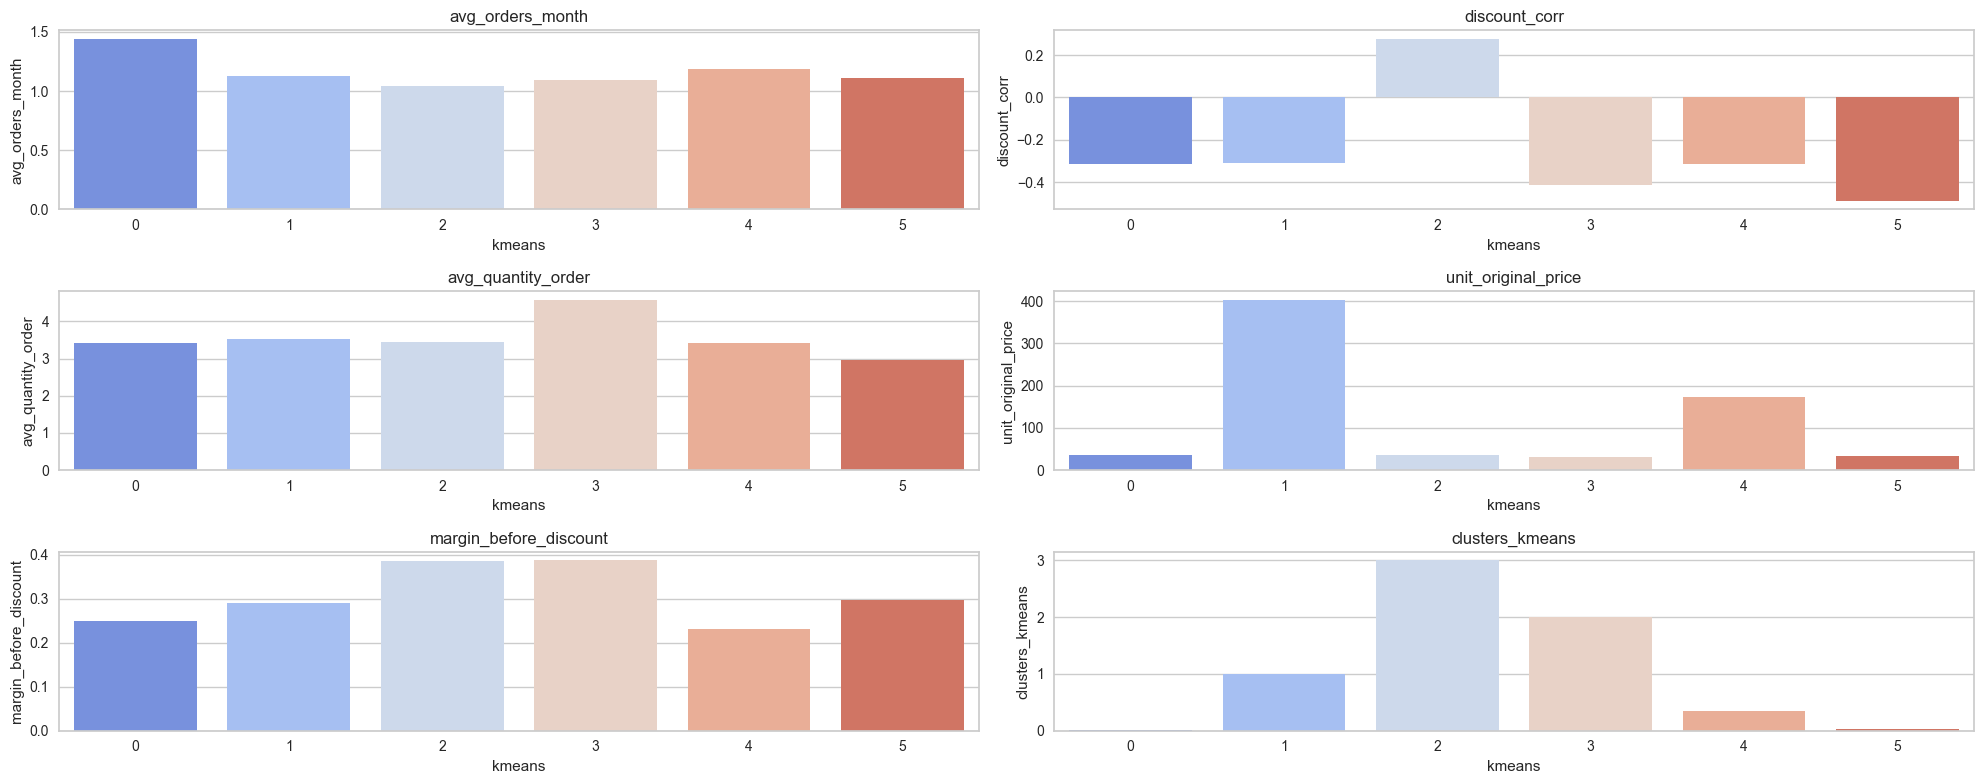

In [39]:
warnings.filterwarnings("ignore")
product_aggregated_outliers = product_aggregated_outliers.astype("float")
clusterizador = sc.Clustering(product_aggregated_outliers)

# 
clusterizador.preparar_dataframe(scaler="robust")

product_aggregated_clustered = clusterizador.modelo_kmeans(product_aggregated_outliers,6)

sns.pairplot(product_aggregated_clustered, hue="clusters_kmeans")

clusterizador.plot_clusters("kmeans")

warnings.filterwarnings("default")

In [40]:
clusterizador.calcular_metricas("kmeans")

silhouette_score  davies_bouldin_index  cardinalidad
0          0.218309              1.412224           796

In [41]:
clusterizador.calcular_metricas("kmeans")
print("Clustering cardinality:")
product_aggregated_clustered.groupby("clusters_kmeans").size()

Clustering cardinality:


clusters_kmeans
0    796
1    309
2    555
3    762
4    526
5    726
dtype: int64

# 3. Comments and selection

In [ ]:
# recreate chosen clusters
product_aggregated_clustered = clusterizador.modelo_kmeans(product_aggregated_outliers,6)

# save clusters data
path_dir = "../data/clusters"
os.makedirs(path_dir,exist_ok=True)
product_aggregated_clustered.to_pickle(f"{path_dir}/product_aggregated_clustered_kmeans_4k.pkl")